# Setup

In [3]:
import plotly.io as pio
try:
    import google.colab
    print("Running as a Colab notebook")
    pio.renderers.default = "colab"
    %pip install transformer-lens fancy-einsum
    %pip install -U kaleido # kaleido only works if you restart the runtime. Required to write figures to disk (final cell)
except:
    print("Running as a Jupyter notebook")
    pio.renderers.default = "vscode"
    from IPython import get_ipython
    ipython = get_ipython()

Running as a Jupyter notebook


In [4]:
import torch
from fancy_einsum import einsum
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils, ActivationCache
from torchtyping import TensorType as TT
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import einops
from typing import List, Union, Optional
from functools import partial
import pandas as pd
from pathlib import Path
import urllib.request
from bs4 import BeautifulSoup
from tqdm import tqdm
from datasets import load_dataset
import os
import json

os.environ["TOKENIZERS_PARALLELISM"] = "false" # https://stackoverflow.com/q/62691279
torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
!pip install circuitsvis
import circuitsvis as cv


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [6]:
pio.renderers.default='vscode'

def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [116]:
model = HookedTransformer.from_pretrained(
    "gpt2-large",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    device=device,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-large into HookedTransformer


## Generate Prompts For GPT-4 Example Generation

In [ ]:
# Relevant Files
# iteration_prompts_ref_1.pkl is the result, with {head: [positive gen, negative gen, positive evaled, negative evaled]}
# head_explanation_1_nh_to_exp.json is the generated explanation, with {head: "explanation"}

In [7]:
import pickle
with open("data/iteration_prompts_ref_1.pkl", "rb") as f:
    generation_eval = pickle.load(f)

with open("data/head_explanation_1_nh_to_exp.json", "rb") as f:
    nh_to_explanation = json.load(f)

nh_to_explanation = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in nh_to_explanation.items()}

with open("data/neuron_finder_results.json", "r") as f:
    neuron_finder_results = json.load(f)

with open("data/head_explanation_1_prompts.json", "r") as f:
    given_categories = json.load(f)

given_categories = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in given_categories.items()}

with open("data/categorised_prompts_1.pkl", "rb") as f:
    categorised_prompts = pickle.load(f)


neuron_to_token = {}

for layer in neuron_finder_results.keys():
    for neuron_ind in neuron_finder_results[layer].keys():
        neuron_to_token[(int(layer), int(neuron_ind))] = neuron_finder_results[layer][neuron_ind][0]

with open("data/head_explanation_1_prompts.json", "r") as f:
    max_activating_categorised = json.load(f)

max_activating_categorised = {tuple(int(value.strip()) for value in k.strip('()').split(',')): v for k,v in max_activating_categorised.items()}

In [8]:
# Load Dataset
from activating_dataset import ActivatingDataset

# Load Neuron
# try:
#     dataset = load_dataset("NeelNanda/pile-10k", split="train")
# except: # this is a hack to let me work offline
#     import pickle
#     with open("dataset.pkl", "rb") as f:
#         dataset = pickle.load(f)

import pickle
with open("data/text_list_dict_test.pkl", "rb") as f:
    dataset = pickle.load(f)

# print(dataset[0])

data = ActivatingDataset('data/neuron_20_examples_test.json', dataset)
print(data.markers)
data_markers = {}
# data markers is {key: [[a, b, c, d, e], [a, b, c, d, e]]}
# we want to make it {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e}, ...]}
data_markers = {key: [{'act': a, 'start': b, 'end': c, 'index': d, 'partact': e} for a, b, c, d, e in value] for key, value in data.markers.items()}
data.markers = data_markers

data.remove_prompts_longer_than(100)
neurons = list(data.markers.keys())

{(31, 3621): [[10.251951217651367, 867, 961, 510, 8.210393905639648], [10.188377380371094, 310, 315, 418, 9.43882942199707], [10.177841186523438, 438, 603, 520, 7.3954033851623535], [9.966235160827637, 464, 731, 5317, 3.7133500576019287], [9.487281799316406, 409, 414, 2899, 6.246142387390137], [9.439425468444824, 113, 156, 7545, 6.262213230133057], [9.430610656738281, 174, 232, 4284, 6.710473537445068], [9.34101676940918, 81, 185, 4034, 6.5010480880737305], [9.274694442749023, 110, 125, 7126, 7.18107795715332], [9.274541854858398, 112, 117, 2018, 6.246142387390137], [9.186296463012695, 4, 9, 9169, 6.246142387390137], [8.998616218566895, 133, 283, 1496, 7.681527137756348], [8.982619285583496, 49, 114, 3843, 6.47260046005249], [8.976102828979492, 323, 449, 7196, 6.426324367523193], [8.974493026733398, 195, 200, 200, 6.088919639587402], [8.886434555053711, 983, 991, 3751, 7.5927300453186035], [8.856136322021484, 266, 400, 1894, 7.205070495605469], [8.831971168518066, 623, 700, 1005, 8.010

In [21]:
def get_head_attribution(cache, tokens, neuron):
    # Get prompt lengths
    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # Get the correct last-seq for each prompt (since they are padded, the last seq position differs for each prompt)
    head_output = cache.stack_head_results()
    expanded_index_tensor = prompt_lengths.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(head_output.shape[0], head_output.shape[1], 1, head_output.shape[-1])
    head_output_last_seq = torch.gather(head_output, 2, expanded_index_tensor).squeeze(2)

    # Get dot product of neuron with each head's output

    layer, no = neuron
    neuron_w_in = model.W_in[layer, :, no]
    head_attribution = einsum("head batch weight, weight->batch head", head_output_last_seq, neuron_w_in)
    head_attribution = head_attribution[:, :layer*model.cfg.n_heads] # Filter for only heads before the neuron
    return head_attribution # Shape [batch, head]

In [23]:
device = 'cpu'
model.to(device)

Moving model to device:  cpu


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook

In [ ]:
save_file = False

In [24]:
head_attribution_dict = {}

for neuron in tqdm(neurons):
    # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
    trunc_prompts = data.load_truncated_prompts(model, neuron)

    # Run head attribution
    tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
    original_logits, cache = model.run_with_cache(tokens, )

    # # Prepare prompts by heads
    head_attribution = get_head_attribution(cache, tokens, neuron)
    _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
    top_heads_list = top_heads.tolist()

    head_results = {}
    for i, prompt in enumerate(trunc_prompts):
        head_results[prompt] = top_heads_list[i]

    head_attribution_dict[str(neuron)] = head_results

# Save results
if save_file:
    with open("head_attribution_dict_test.json", "w") as f:
        json.dump(head_attribution_dict, f)
    save_file = False

  0%|          | 0/50 [00:00<?, ?it/s]

Tried to stack head results when they weren't cached. Computing head results now


  2%|▏         | 1/50 [00:13<10:49, 13.25s/it]

Tried to stack head results when they weren't cached. Computing head results now


  4%|▍         | 2/50 [00:23<09:19, 11.65s/it]

Tried to stack head results when they weren't cached. Computing head results now


  6%|▌         | 3/50 [00:32<08:13, 10.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


  8%|▊         | 4/50 [00:41<07:35,  9.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


 10%|█         | 5/50 [00:46<05:58,  7.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


 12%|█▏        | 6/50 [00:57<06:31,  8.91s/it]

Tried to stack head results when they weren't cached. Computing head results now


 14%|█▍        | 7/50 [01:08<06:52,  9.60s/it]

Tried to stack head results when they weren't cached. Computing head results now


 16%|█▌        | 8/50 [01:18<06:56,  9.93s/it]

Tried to stack head results when they weren't cached. Computing head results now


 18%|█▊        | 9/50 [01:25<06:01,  8.81s/it]

Tried to stack head results when they weren't cached. Computing head results now


 20%|██        | 10/50 [01:31<05:16,  7.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


 22%|██▏       | 11/50 [01:41<05:36,  8.63s/it]

Tried to stack head results when they weren't cached. Computing head results now


 24%|██▍       | 12/50 [01:50<05:36,  8.87s/it]

Tried to stack head results when they weren't cached. Computing head results now


 26%|██▌       | 13/50 [01:57<05:09,  8.37s/it]

Tried to stack head results when they weren't cached. Computing head results now


 28%|██▊       | 14/50 [02:06<04:59,  8.31s/it]

Tried to stack head results when they weren't cached. Computing head results now


 30%|███       | 15/50 [02:10<04:12,  7.23s/it]

Tried to stack head results when they weren't cached. Computing head results now


 32%|███▏      | 16/50 [02:25<05:22,  9.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


 34%|███▍      | 17/50 [02:33<04:53,  8.88s/it]

Tried to stack head results when they weren't cached. Computing head results now


 36%|███▌      | 18/50 [02:44<05:03,  9.50s/it]

Tried to stack head results when they weren't cached. Computing head results now


 38%|███▊      | 19/50 [02:53<04:55,  9.53s/it]

Tried to stack head results when they weren't cached. Computing head results now


 40%|████      | 20/50 [03:00<04:25,  8.85s/it]

Tried to stack head results when they weren't cached. Computing head results now


 42%|████▏     | 21/50 [03:13<04:49,  9.97s/it]

Tried to stack head results when they weren't cached. Computing head results now


 44%|████▍     | 22/50 [03:24<04:47, 10.28s/it]

Tried to stack head results when they weren't cached. Computing head results now


 46%|████▌     | 23/50 [03:34<04:36, 10.25s/it]

Tried to stack head results when they weren't cached. Computing head results now


 48%|████▊     | 24/50 [03:44<04:21, 10.07s/it]

Tried to stack head results when they weren't cached. Computing head results now


 50%|█████     | 25/50 [03:49<03:37,  8.70s/it]

Tried to stack head results when they weren't cached. Computing head results now


 52%|█████▏    | 26/50 [04:01<03:53,  9.72s/it]

Tried to stack head results when they weren't cached. Computing head results now


 54%|█████▍    | 27/50 [04:09<03:31,  9.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


 56%|█████▌    | 28/50 [04:20<03:31,  9.64s/it]

Tried to stack head results when they weren't cached. Computing head results now


 58%|█████▊    | 29/50 [04:26<02:59,  8.56s/it]

Tried to stack head results when they weren't cached. Computing head results now


 60%|██████    | 30/50 [04:33<02:43,  8.18s/it]

Tried to stack head results when they weren't cached. Computing head results now


 62%|██████▏   | 31/50 [04:42<02:36,  8.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


 64%|██████▍   | 32/50 [04:55<02:54,  9.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


 66%|██████▌   | 33/50 [05:03<02:36,  9.21s/it]

Tried to stack head results when they weren't cached. Computing head results now


 68%|██████▊   | 34/50 [05:09<02:11,  8.20s/it]

Tried to stack head results when they weren't cached. Computing head results now


 70%|███████   | 35/50 [05:17<02:03,  8.23s/it]

Tried to stack head results when they weren't cached. Computing head results now


 72%|███████▏  | 36/50 [05:26<01:57,  8.41s/it]

Tried to stack head results when they weren't cached. Computing head results now


 74%|███████▍  | 37/50 [05:36<01:55,  8.90s/it]

Tried to stack head results when they weren't cached. Computing head results now


 76%|███████▌  | 38/50 [05:38<01:23,  6.98s/it]

Tried to stack head results when they weren't cached. Computing head results now


 78%|███████▊  | 39/50 [05:44<01:13,  6.68s/it]

Tried to stack head results when they weren't cached. Computing head results now


 80%|████████  | 40/50 [05:57<01:25,  8.54s/it]

Tried to stack head results when they weren't cached. Computing head results now


 82%|████████▏ | 41/50 [06:07<01:18,  8.75s/it]

Tried to stack head results when they weren't cached. Computing head results now


 84%|████████▍ | 42/50 [06:18<01:17,  9.71s/it]

Tried to stack head results when they weren't cached. Computing head results now


 86%|████████▌ | 43/50 [06:31<01:14, 10.59s/it]

Tried to stack head results when they weren't cached. Computing head results now


 88%|████████▊ | 44/50 [06:38<00:57,  9.55s/it]

Tried to stack head results when they weren't cached. Computing head results now


 90%|█████████ | 45/50 [06:46<00:44,  8.92s/it]

Tried to stack head results when they weren't cached. Computing head results now


 92%|█████████▏| 46/50 [06:58<00:39,  9.82s/it]

Tried to stack head results when they weren't cached. Computing head results now


 94%|█████████▍| 47/50 [07:11<00:32, 10.86s/it]

Tried to stack head results when they weren't cached. Computing head results now


 96%|█████████▌| 48/50 [07:20<00:20, 10.41s/it]

Tried to stack head results when they weren't cached. Computing head results now


 98%|█████████▊| 49/50 [07:34<00:11, 11.35s/it]

Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 50/50 [07:40<00:00,  9.22s/it]


In [25]:
print(list(head_attribution_dict.values())[0])

{' our community will love it also. I only wish that this resource was available when I was a new mom!!!  This video was ordered for our Huntington Hospital Community Health Library. I screened it, and I have to say that it was very informative! I am a mother of 3 and a grandmother of 3 and this video was still able to teach me quite a few tips on baby care! I loved it and I know that our community will love it also. I': [468, 410, 496], ' website are for identification purposes': [538, 517, 88], ' data is for informational purposes': [538, 559, 360], "  may only appear once in this section.> Then I try to build the solution then  I'm getting error on Output Error CS1029 error: 'Generation error: The element  may": [468, 410, 496], " for clarity only. Optimized only if necessary.  No one cares if your function thats called once a month takes an extra few seconds to run.  ~~~ sbov > I'll go one step further... all new code should be written for clarity": [468, 410, 496], ' All graphs, c

In [9]:
import importlib
import prompt_generators
importlib.reload(prompt_generators)
from prompt_generators import ClassifyPromptGen

In [10]:
with open("data/head_attribution_dict_test.json", "r") as f:
    head_attribution_dict = json.load(f)

In [252]:
print(head_attribution_dict)

{'(31, 3621)': {' our community will love it also. I only wish that this resource was available when I was a new mom!!!  This video was ordered for our Huntington Hospital Community Health Library. I screened it, and I have to say that it was very informative! I am a mother of 3 and a grandmother of 3 and this video was still able to teach me quite a few tips on baby care! I loved it and I know that our community will love it also. I': [468, 410, 496], ' website are for identification purposes': [538, 517, 88], ' data is for informational purposes': [538, 559, 360], "  may only appear once in this section.> Then I try to build the solution then  I'm getting error on Output Error CS1029 error: 'Generation error: The element  may": [468, 410, 496], " for clarity only. Optimized only if necessary.  No one cares if your function thats called once a month takes an extra few seconds to run.  ~~~ sbov > I'll go one step further... all new code should be written for clarity": [468, 410, 496], 

In [65]:
nh_list = list(nh_to_explanation.keys())
prompt_to_nh = {}

for nh in nh_list:
    neuron = (nh[0], nh[1])
    token = neuron_to_token[neuron]

    example_list = list(head_attribution_dict[str(neuron)].keys())
    example_list = [example + token for example in example_list]

    explanation = nh_to_explanation[nh]

    for example in example_list:

        prompt_gen = ClassifyPromptGen(example=example, token=token, explanation_str=explanation)
        prompt = prompt_gen.get_prompt()
        prompt_to_nh[prompt] = [nh] if prompt not in prompt_to_nh else prompt_to_nh[prompt] + [nh]

print(len(prompt_to_nh))

2812


In [150]:
print(list(prompt_to_nh.keys())[28])

Is the given example an active example? (Yes/No)
The example is active when the example contains the word "only" at or near the end of a sentence or phrase and is used to emphasize a singular purpose, reason, or exclusivity. In the active examples, "only" is found either at the end of the sentence or closely following a clause which emphasizes a specific purpose (e.g., "for educational purposes only" or "known only").  In the inactive examples, although the word "only" is present, it does not hold the same emphasis on exclusivity or it is located at other positions in the text and not near the end. The context of "only" in inactive examples is often connected to being part of a condition or limitation (e.g., "can only work if you are following" or "only available in Mexico") and not used as a singular emphasis on purpose or reason.
Example: """
 data is for informational purposes only
"""
Answer: 


In [250]:
i=0

In [251]:
i += 1
print(list(iter(prompt_to_nh.values()))[i])

(31, 3621, 468)


In [236]:
import tiktoken

# Check how many tokens are in the prompt
encoding = tiktoken.encoding_for_model("gpt-4")
prompt_counts = [len(encoding.encode(prompt)) for prompt in prompt_to_nh.keys()]
len(prompt_counts)

2900

In [283]:
import json
import os
filename = "data/eg_classify_1.jsonl"

if os.path.isfile(filename):
    raise Exception("File already exists!")

prompts = list(prompt_to_nh.keys())

jobs = [
            {"model":"gpt-4",
            "messages":[{"role": "user", "content": gpt_4_prompt}],
            "max_tokens":1, 
        # } for gpt_4_prompt in eg_generation_prompts.values()]
        } for gpt_4_prompt in prompts]

with open(filename, "w") as f:
    for job in jobs:
        json_string = json.dumps(job)
        f.write(json_string + "\n")

In [ ]:
import time
now = int(time.time())
print(now)

#########################################################################################
# WHEN YOU UPDATE THE CELL, REMEMBER TO UPDATE THE JSONL FILE NAME IF YOU'VE CHANGED IT #
#########################################################################################
current_time = 1686792857

if current_time + 20 < now: # Sanity check to make sure you don't spam this cell
    raise Exception("Update the current_time variable to be able to run this cell! Copy and paste the number above.")
else:
    print("all gucci")
    !python3 api_request_parallel_processor.py --requests_filepath data/eg_sorting_1.jsonl --request_url https://api.openai.com/v1/chat/completions --max_requests_per_minute 100 --max_tokens_per_minute 20000
    # ^ This is very scary because the stdout looks like it sends repeated requests for the same thing so just run it in terminal


In [13]:
with open('data/eg_classify_1_results.jsonl', 'r') as json_file:
    classification_results = list(json_file)

In [14]:
prompt_to_response = {}
# neuron_head_to_response = {}
# neuron_head_to_prompt = prompt
# neuron_heads = list(neuron_head_to_prompt.keys())

for i, json_str in enumerate(classification_results):
    result = json.loads(json_str)
    prompt = result[0]["messages"][0]["content"]
    response = result[1]["choices"][0]["message"]["content"]
    prompt_to_response[prompt] = response

In [151]:
nh_to_results = {}
# Here are the variables
nh_to_egs = {}
nh_to_egs_correct = {}
for nh in nh_list:
    neuron, head = (nh[0], nh[1]), nh[2]
    token = neuron_to_token[neuron]
    relevant_prompts = [prompt for prompt in prompt_to_response.keys() if nh in prompt_to_nh[prompt]]
    # relevant_prompts = list(prompt_to_response.keys())
    relevant_egs = [prompt.split('"""')[1][1:-1-len(token)] for prompt in relevant_prompts]
    tn, fn, fp, tp = 0, 0, 0, 0
    egs_dict = {"tp":[], "fp":[], "tn":[], "fn":[]}
    for i, eg in enumerate(relevant_egs):
        # break
        good_heads = head_attribution_dict[str(neuron)][eg]
        response = prompt_to_response[relevant_prompts[i]]
        if head in good_heads:
            if response == "Yes":
                tp += 1
                egs_dict["tp"].append(eg)
            elif response == "No":
                fn += 1
                egs_dict["fn"].append(eg)
            else:
                raise Exception("Response is not Yes or No!")
        else:
            if response == "Yes":
                fp += 1
                egs_dict["fp"].append(eg)
            elif response == "No":
                tn += 1
                egs_dict["tn"].append(eg)
            else:
                raise Exception("Response is not Yes or No!")
    nh_to_results[nh] = {"tn":tn, "fn":fn, "fp":fp, "tp":tp}
    nh_to_egs[nh] = relevant_egs
    nh_to_egs_correct[nh] = egs_dict

In [152]:
# save nh_to_egs_correct
nh_to_egs_correct_str_key = {str(k):v for k,v in nh_to_egs_correct.items()}
with open("data/nh_to_egs_results.json", "w") as f:
    json.dump(nh_to_egs_correct_str_key, f)

(0.0, 1.0)

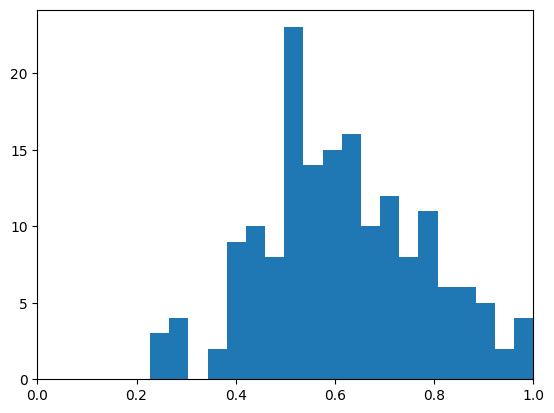

In [114]:
# For each nh, print accuracy (i.e. tp + tn / total)
nh_accuracies = {}
true_positives = {}
true_negatives = {}
head_exp_score = {} # average of tpr and tnr

for nh in nh_list:
    tp, fp, tn, fn = nh_to_results[nh]["tp"], nh_to_results[nh]["fp"], nh_to_results[nh]["tn"], nh_to_results[nh]["fn"]
    nh_accuracies[nh] = (tp + tn) / (tp + fp + tn + fn)
    try:
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
    except:
        continue
    true_positives[nh] = tpr
    true_negatives[nh] = tnr
    head_exp_score[nh] = (tpr + tnr) / 2

# plot the histogram
import matplotlib.pyplot as plt
# plt.hist(list(nh_accuracies.values()), bins=20)
plt.hist(list(head_exp_score.values()), bins=20)
# Put the x range from 0 to 1
plt.xlim(0, 1)

# Sort the nh by accuracy
# sorted_nh_accuracies = sorted(nh_accuracies.items(), key=lambda x: x[1], reverse=True)

Text(0, 0.5, 'True Negative Rate')

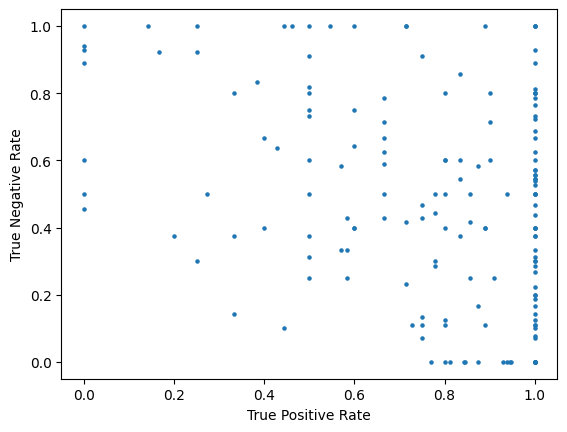

In [111]:
# Scatter the nh by both true positive and true negative rates
import matplotlib.pyplot as plt
plt.scatter(list(true_positives.values()), list(true_negatives.values()), s=5)
plt.xlabel("True Positive Rate")
plt.ylabel("True Negative Rate")

In [132]:
prompts = nh_to_egs[(31, 364, 548)]

# x = model(prompts)
token = neuron_to_token[(31, 364)]
print(token)
# Get top predictions for each batch
prompt_tokens = [model.tokenizer.encode(prompt) for prompt in prompts]
prompt_token_lengths = [len(prompt) for prompt in prompt_tokens]

x_cut = [x[i, prompt_token_lengths[i], :] for i in range(len(prompts))]

top_preds = [torch.topk(x_cut[i], 1) for i in range(len(x_cut))]

top_preds = [model.tokenizer.decode(pred.indices[0].item()) for pred in top_preds]

for prompt, pred in zip(prompts, top_preds):
    print(prompt, " -> ", pred)

# Get the token number
token_num = model.tokenizer.encode(token)[0]

# Get the softmaxed probability of the token
softmaxed = [torch.softmax(x_item, dim=-1) for x_item in x_cut]
softmaxed = [x_item[token_num].item() for x_item in softmaxed]

print(softmaxed)


 number
 Music.  43 Minutes peaked at  ->   #
 a different chromosome number (2n = 46) and is found on the Kermadec Islands, North Island, northern South Island and Chatham Islands of New Zealand, while S. laciniatum has much larger, rotate, darker purple flowers with broad, flared (ruffled) corolla lobes with rounded apices, larger seeds that are  long, and a different chromosome  ->   number
 country charts in 2000, peaking at  ->   #
 1. Full Name 2. Phone and Fax  ->   Number
 model, caliber and serial  ->   number
 database are assigned an unique personalized identification  ->   number
 Hot 100, where it peaked at  ->   No
 entered the Australian charts at  ->   number
) at the address and phone  ->   number
 my Top 5 Poker Troublemakers and put Daniel Negreanu in at  ->   #
 Sequence Read Archive (DRA) with accession  ->   number
 Feeling" debuted at  ->   No
 album debuted at  ->   #
 WhatsApp.  The teacher asked all of her students to provide her with their telephone  ->   num

In [ ]:
check_if_responses_can_be_processed = False # Do this first
iteration_prompts = {}
iteration_prompts_ref = {}

for i, (neuron_head, generated_example) in tqdm(enumerate(generated_examples.items())):
    neuron, head_no = (neuron_head[0], neuron_head[1]), neuron_head[2]
    relevant_token = neuron_to_token[neuron]

    capitalised_token = relevant_token[0] + relevant_token[1].capitalize() + relevant_token[2:] # we can do this because by definition we got " word" tokens
    
    if 'is_inactive' in generated_example:
        generated_example = generated_example.replace('is_inactive', 'is inactive') # For some reason this was in one prompt

    # Extract the positive and negative examples. 
    def get_list_of_strings(string):
        return [s[3:] if s[1] == "." else s[4:] for s in string.split("\n") if s != ''] # Wonky but it works

    positive_examples = generated_example.split("Examples where the attention head is active:")[1].split("Examples where the attention head is inactive:")[0]
    negative_examples = generated_example.split("Examples where the attention head is inactive:")[1]
    positive_examples = get_list_of_strings(positive_examples)
    negative_examples = get_list_of_strings(negative_examples)

    # Cut off the examples at the last instance of <token>. They may happen more than once.
    positive_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in positive_examples]
    negative_examples = [eg[:max(eg.rfind(relevant_token), eg.rfind(capitalised_token))] for eg in negative_examples]

    if not check_if_responses_can_be_processed:
        # Load and Truncate Prompts (slightly cursed way of string -> token -> truncated tokens -> string)
        trunc_prompts = positive_examples + negative_examples
        # Run head attribution
        tokens = model.to_tokens(trunc_prompts, prepend_bos=True).to(device=device)
        original_logits, cache = model.run_with_cache(tokens, )

        # # Prepare prompts by heads
        head_attribution = get_head_attribution(model, cache, tokens, neuron)
        _, top_heads = torch.topk(head_attribution, k=3, dim=-1)
        top_heads_list = top_heads.tolist()

        top_heads_positive = top_heads_list[:len(positive_examples)]
        top_heads_negative = top_heads_list[len(positive_examples):]

        positive_examples_correct = []
        negative_examples_correct = []

        for i, example in enumerate(positive_examples):
            if head_no in top_heads_positive[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        for i, example in enumerate(negative_examples):
            if head_no in top_heads_negative[i]:
                positive_examples_correct.append(example)
            else:
                negative_examples_correct.append(example)

        explanation_str = nh_to_exp[neuron_head].replace("\n", "")
        iter_gen = IterationPromptGen(positive_examples, negative_examples, positive_examples_correct, negative_examples_correct, relevant_token, explanation_str)
        iteration_prompt = iter_gen.get_prompt()

        iteration_prompts[neuron_head] = iteration_prompt
        iteration_prompts_ref[neuron_head] = [positive_examples, negative_examples, positive_examples_correct, negative_examples_correct]

In [ ]:
def get_head_attribution(cache, tokens, neuron):
    # Get prompt lengths
    pad_token = bos_token = 50256 # This is true for GPT-2
    prompt_lengths = (torch.logical_and(tokens != pad_token, tokens != bos_token)).sum(dim=-1)

    # Get the correct last-seq for each prompt (since they are padded, the last seq position differs for each prompt)
    head_output = cache.stack_head_results()
    expanded_index_tensor = prompt_lengths.unsqueeze(0).unsqueeze(-1).unsqueeze(-1).expand(head_output.shape[0], head_output.shape[1], 1, head_output.shape[-1])
    head_output_last_seq = torch.gather(head_output, 2, expanded_index_tensor).squeeze(2)

    # Get dot product of neuron with each head's output

    layer, no = neuron
    neuron_w_in = model.W_in[layer, :, no]
    head_attribution = einsum("head batch weight, weight->batch head", head_output_last_seq, neuron_w_in)
    head_attribution = head_attribution[:, :layer*model.cfg.n_heads] # Filter for only heads before the neuron
    return head_attribution # Shape [batch, head]

In [9]:
accuracies = {}
accuracy_balanced = {}
accuracies_positive = {}
accuracies_negative = {}
f1s = {}
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in generation_eval.items():
    cat_prompts_positive, cat_prompts_negative = categorised_prompts[head]
    # if len(cat_prompts_positive)/(len(cat_prompts_positive)+len(cat_prompts_negative)) > 0.75:
    #     print("SKIP")
    #     continue

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1

    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative[head] = accuracy_negative
    accuracy_balanced[head] = (accuracy_positive+accuracy_negative)/2
    accuracies[head] = (accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s[head] = (f1)



print(np.mean(list(accuracies.values())))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(list(accuracies_negative.values())))
print(np.mean(list(f1s.values())))
print(np.mean(list(accuracy_balanced.values())))

0.5884469696969696
0.405965909090909
0.7704545454545454
0.411324878114303
0.5882102272727273


In [10]:
scatter(np.arange(len(f1s.values())), list(f1s.values()))

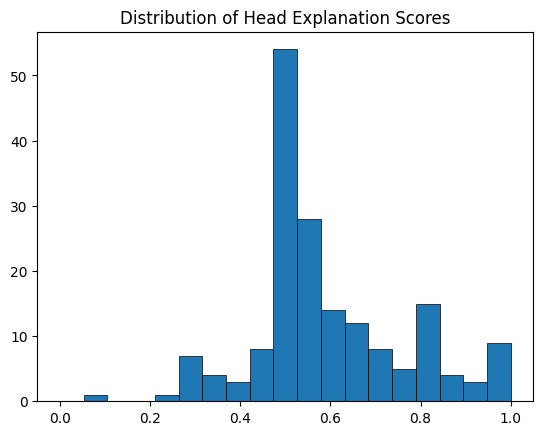

In [11]:
bins = np.linspace(0, 1, 20)
import matplotlib.pyplot as plt
plt.hist(accuracy_balanced.values(), bins, label='Overall Accuracy', linewidth=0.5, edgecolor="black")
plt.title("Distribution of Head Explanation Scores")
plt.savefig("hist.pdf")

In [ ]:
x = list(accuracies_positive.values())
y = list(accuracies_negative.values())
print(list(zip(x, y)))
print(list(f1s.values()))

[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0), (0.6, 1.0), (0.6, 1.0), (0.6, 0.0), (0.0, 0.9), (0.6, 1.0), (0.2, 1.0), (0.0, 1.0), (0.0, 0.8), (0.2, 0.5), (0.3, 0.8), (0.2, 1.0), (0.3, 0.4), (0.1, 1.0), (0.6, 1.0), (0.1, 1.0), (0.7, 0.9), (0.6, 1.0), (0.7, 0.7), (0.1, 0.8), (0.5, 0.8), (0.6, 0.7), (0.1, 1.0), (0.7, 0.8), (0.7, 0.4), (0.6, 0.8), (0.7, 1.0), (0.8, 0.4), (1.0, 0.3), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.2), (0.3, 0.7), (0.7, 0.9), (0.9, 0.3), (0.5, 0.6), (0.8, 0.7), (0.0, 0.9), (0.4, 0.8), (0.0, 1.0), (0.6, 0.8), (0.9, 0.4), (0.4, 1.0), (0.2, 1.0), (0.5, 0.8), (0.6, 1.0), (0.3, 0.8), (0.0, 1.0), (0.5, 1.0), (0.0, 1.0), (0.1, 1.0), (0.4, 0.2), (0.3, 1.0), (0.0, 1.0), (0.3, 0.8), (0.0, 1.0), (1.0, 0.0), (0.0, 1.0), (0.0, 1.0), (0.2, 0.9), (0.4, 0.8), (0.5, 0.8), (0.6, 0.8), (0.5, 1.0), (0.3, 1.0), (1.0, 0.0), (0.

In [260]:
(grid[6:, 6:].sum() / grid.sum()) * 100

21.59090909090909

[0.0, 0.0, 1.0, 0.4, 0.4, 0.1, 0.9, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8, 0.5, 0.1, 0.9, 0.6, 0.6, 0.6, 0.0, 0.6, 0.2, 0.0, 0.0, 0.2, 0.3, 0.2, 0.3, 0.1, 0.6, 0.1, 0.7, 0.6, 0.7, 0.1, 0.5, 0.6, 0.1, 0.7, 0.7, 0.6, 0.7, 0.8, 1.0, 0.0, 0.0, 0.0, 0.8, 0.3, 0.7, 0.9, 0.5, 0.8, 0.0, 0.4, 0.0, 0.6, 0.9, 0.4, 0.2, 0.5, 0.6, 0.3, 0.0, 0.5, 0.0, 0.1, 0.4, 0.3, 0.0, 0.3, 0.0, 1.0, 0.0, 0.0, 0.2, 0.4, 0.5, 0.6, 0.5, 0.3, 1.0, 0.9, 0.6, 0.3, 0.0, 0.1, 0.1, 0.4, 0.3, 0.0, 0.4, 0.0, 0.0, 0.2, 0.0, 0.5, 0.7, 0.0, 0.0, 0.0, 0.3, 1.0, 0.0, 0.0, 0.6, 0.9, 0.7, 0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 1.0, 0.9, 0.8, 0.0, 1.0, 0.5, 0.0, 0.0, 0.7, 1.0, 0.0, 0.0, 0.0, 1.0, 0.2, 0.4, 0.2, 0.3, 1.0, 0.0, 0.2, 0.6, 0.2, 0.7, 0.0, 0.6, 0.0, 1.0, 0.3, 1.0, 0.7, 0.4, 0.0, 0.1, 0.5, 0.45, 0.0, 0.0, 0.0, 0.3, 0.4]
[(0.0, 1.0), (0.0, 1.0), (1.0, 1.0), (0.4, 0.8), (0.4, 0.1), (0.1, 1.0), (0.9, 1.0), (0.2, 0.4), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.8, 0.9), (0.5, 0.8), (0.1, 0.8), (0.9, 1.0)

[Text(0.5, 1.0, 'Distribution of True Positive and True Negative Rates over all heads\n')]

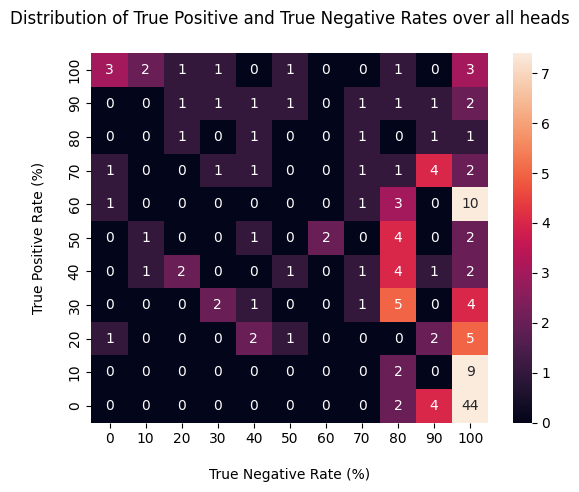

In [261]:

import seaborn as sb

# Create a 2D array filled with zeros
grid = np.zeros((11, 11), dtype=int)
print(x)

# Iterate through the values in x and y
zipped_list = list(zip(x, y))
print(zipped_list)
for x_item, y_item in zipped_list:
    # Iterate through the values in x and y
    # Increment the count in the grid at the corresponding position
    grid[int(x_item*10), int(y_item*10)] +=  1


ax = sb.heatmap(grid, annot=True, robust=True, xticklabels=[i*10 for i in range(11)], yticklabels=[i*10 for i in range(11)])
ax.invert_yaxis()
ax.set(xlabel="\nTrue Negative Rate (%)", ylabel="True Positive Rate (%)\n")
ax.set(title="Distribution of True Positive and True Negative Rates over all heads\n")

In [13]:
tnr = 10
tpr = 10

head_list = []
for head, accuracy_positive in accuracies_positive.items():
    accuracy_negative = accuracies_negative[head]
    if int(accuracy_positive * 10) == tpr and int(accuracy_negative * 10) == tnr:
        head_list.append(head)

print(head_list)
print(len(head_list))


[(31, 3621, 538), (32, 3151, 546), (32, 3151, 496), (34, 4410, 604), (35, 3360, 691), (35, 885, 549)]
6


In [ ]:
print(len(categorised_prompts[(31, 3621, 468)]))

2


In [18]:
def get_head_results(nh, gen_results, nh_to_exp, neuron_to_token, categorised_prompts):
    gen_positive, gen_negative, eval_positive, eval_negative = gen_results[nh]
    balanced_accuracy = accuracy_balanced[nh]

    return_str = f"## {nh} — {balanced_accuracy:.2f} Accuracy \n"
    return_str += f'Neuron helps to predict the token "{neuron_to_token[(nh[0],nh[1])]}".\n'
    positive_egs, negative_egs = categorised_prompts[nh]

    return_str += f"\n### Max-Activating Data from The Pile\n"

    return_str += "Examples where the attention head is active:\n"
    for i, positive_eg in enumerate(positive_egs):
        return_str += f"{i}. {positive_eg}\n"

    return_str += "\nExamples where the attention head is inactive:\n"
    for i, negative_eg in enumerate(negative_egs):
        return_str += f"{i}. {negative_eg}\n"

    return_str += f"\nGPT-4's Explanation: \n   The head is active when the document {nh_to_exp[nh]}\n"

    return_str += f"\n### Synthetic Data from GPT-4\n"

    return_str += "Examples where the attention head is active:\n"
    for i, eg in enumerate(gen_positive):
        return_str += f"{i}. "
        if eg in eval_positive:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    return_str += "\nExamples where the attention head is inactive:\n"
    for i, eg in enumerate(gen_negative):
        return_str += f"{i}. "
        if eg in eval_negative:
            return_str += "✅ "
        else:
            return_str += "❌ "
        return_str += f"{eg}\n"
    
    return balanced_accuracy, return_str

accuracy, result = get_head_results(head_list[0], generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)

print(result)

## (31, 3621, 538) — 1.00 Accuracy 
Neuron helps to predict the token " only".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  for one reason and one reason only
1.  site is for informational purposes only
2. known result "$X$ is ${\rm T}_1$ if and only
3.  Software that is described herein is for illustrative purposes only
4.  is intended for general information purposes only
5.  Disclaimer: The Body is designed for educational purposes only
6.  is intended for entertainment purposes only
7.  directory, ("Find A Doctor"), is provided for reference purposes only
8.  this is for informational purposes only

Examples where the attention head is inactive:
0. ire can only work if you are follwoing a proper diet according to your body needs. That is not easy thing for most of the people. To stay healthy, However, It requires you to work hard and stay focused on the end goal. One of the best way to st... moreExcersire can only
1.  becuase we are the on

In [19]:
overview_list = []

for head, accuracy_positive in accuracies_positive.items():
    accuracy, result = get_head_results(head, generation_eval, nh_to_explanation, neuron_to_token, categorised_prompts)
    overview_list.append((accuracy, head, result))

# Sort overview list by first element
overview_list.sort(key=lambda x: x[0], reverse=True)

# Save overview list strings to text file
with open("overview.txt", "w") as f:
    for accuracy, head, result in overview_list:
        f.write(result)
        f.write("\n\n")

In [41]:
ind = 0

In [ ]:
## (31, 3621, 538) — 1.00 Accuracy — for x purposes "only"
## (32, 3151, 546) — 1.00 Accuracy — over and "over"
## (32, 3151, 496) — 1.00 Accuracy — over and "over"
## (34, 4410, 604) — 1.00 Accuracy – as fast/early/high "as"
## (35, 3360, 691) — 1.00 Accuracy — by the "very"... over -> it was very, "very"
## (35, 885, 549) — 1.00 Accuracy — Sentence... "His"
## (31, 364, 548) — 0.95 Accuracy — The number of a document e.g. IMEI "number" passport "number", mobile "number", etc.
## (31, 4378, 123) — 0.95 Accuracy — ... Taken "together"
## (31, 4941, 538) — 0.95 Accuracy — "within" x amount of time
## (34, 5095, 538) — 0.90 Accuracy — working "well", responding "well" — specifically for positive contexts
## (34, 4494, 658) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (34, 4494, 160) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (31, 4378, 538) — 0.85 Accuracy — Bring "together", put two and two "together" — for contexts about merging or joining
## (34, 4494, 641) — 0.90 Accuracy — U. S. Pat "no" — specifically for US Patents only
## (32, 4964, 492) — 0.85 Accuracy — "too" — excessive contexts?
## (35, 5014, 504) — 0.85 Accuracy — " won" — the examples are <won>'t, but GPT-4 doesn't understand that
## (31, 4378, 106) — 0.80 Accuracy — taken "together"
## (31, 4378, 88) — 0.80 Accuracy — taken "together"
## (31, 988, 371) — 0.80 Accuracy — also "called"
## (31, 2692, 559) — 0.80 Accuracy — past vs present e.g. what it "used" to be
## (31, 4941, 466) — 0.80 Accuracy — deadline or timeframe
## (32, 406, 538) — 0.80 Accuracy — ...as "much"
## (33, 4900, 492) — 0.80 Accuracy — a measurement "of"
## (34, 4262, 538) — 0.80 Accuracy — verb "down" e.g. watered down, gunned down
## (34, 4199, 538) — 0.80 Accuracy — sought-" after"

In [74]:
for i, (accuracy, head, result) in enumerate(overview_list):
    if ind != i: 
        continue
    else:
        print(result)
        ind += 1
        break

## (32, 4882, 489) — 0.75 Accuracy 
Neuron helps to predict the token " class".

### Max-Activating Data from The Pile
Examples where the attention head is active:
0.  went to teach a yoga class
1.  evening classes in May 2012, followed by morning class
2.  kind of thing you learn about in introductory general physics class
3.  Science course apart. The once-a-week class
4.  teaching a music-appreciation class
5.  include syllabi and promotional flyers for the first women's studies class
6.  attend gender studies class
7.  general education classroom to do a co-teaching lesson in my classroom. This way I get the opportunity to collaborate with my general education class
8.  am planning on teaching an intro to “Programming for Informaticists” class
9.  not teach headstand in my class

Examples where the attention head is inactive:
0.  teacher who noticed that I was fooling around at the back of the class
1.  an aerobics class
2.  always dabbled. I took a couple soapmaking class
3.  copi

Text(0.5, 1.0, 'Positive Accuracy (Pre_Iteration)')

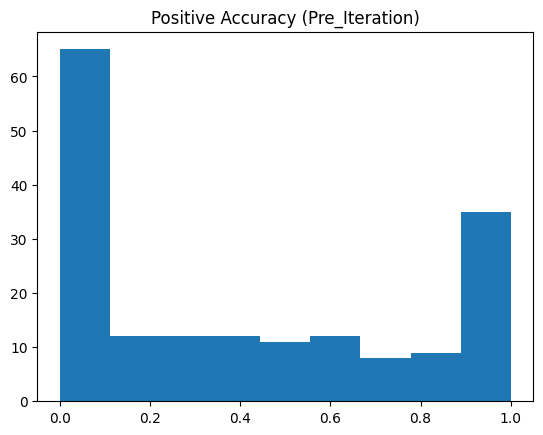

In [84]:
plt.hist(accuracies_positive.values(), bins, label='Positive Accuracy')
plt.title("Positive Accuracy (Pre_Iteration)")

In [63]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Pre-Iteration)",range_y=[-0.1,1.1])

In [64]:
accuracies = []
accuracies_positive = {}
accuracies_negative = []
f1s = []
precisions = []
recalls = []
for head, (pred_pos, pred_neg, correct_pos, correct_neg) in v2.items():
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for eg in pred_pos:
        if eg in correct_pos:
            true_pos += 1
        else:
            false_pos += 1
    for eg in pred_neg:
        if eg in correct_neg:
            true_neg += 1
        else:
            false_neg += 1
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    accuracy_positive = true_pos / (true_pos + false_pos)
    accuracy_negative = true_neg / (true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    try:
        recall = true_pos / (true_pos + false_neg)
        recalls.append(recall)
    except ZeroDivisionError:
        pass
    precisions.append(precision)

    # accuracies_positive.append(accuracy_positive)
    accuracies_positive[head] = accuracy_positive
    accuracies_negative.append(accuracy_negative)
    accuracies.append(accuracy)
    f1 = 2 * true_pos / (2 * true_pos + false_pos + false_neg)
    f1s.append(f1)



print(np.mean(accuracies))
print(np.mean(list(accuracies_positive.values())))
print(np.mean(accuracies_negative))
print(np.mean(f1s))
print(np.mean(precisions))
print(np.mean(recalls))

0.5954229797979799
0.4034090909090909
0.7856534090909091
0.40573377829807455
0.4034090909090909
0.6660497535647056


In [65]:
scatter(np.arange(len(accuracies)), accuracies, title="Overall Accuracy (Post_Iteration)",range_y=[-0.1,1.1])

In [66]:
scatter(np.arange(len(accuracies_positive)), list(accuracies_positive.values()), hover_name=labels, title="Accuracy of Positive Generation (Post-Iteration)", range_y=[-0.1,1.1]) # add hover